In [1]:
import sys
import os
sys.path.append("../")
sys.path.append("../..")
import numpy as np

## 1. Data Ingestion

In [2]:
from setting import influx_setting_KETI as ins
from clust.ingestion.influx import influx_Client_v2 as influx_Client

DBClient = influx_Client.influxClient(ins.CLUSTDataServer)
db_name = 'air_indoor_경로당'
ms_list = DBClient.measurement_list(db_name)
ms_name = ms_list[0]

num = "20000"
input_data = DBClient.get_datafront_by_num(num, db_name, ms_name) 
# input_data

### 1-1. Data Exploration

In [3]:
input_data[['in_co2', 'in_humi']]

,in_co2,in_humi
time,,
2021-02-04 10:33:00+00:00,-9999.0,-9999.0
2021-02-04 10:34:00+00:00,552.0,22.0
2021-02-04 10:35:00+00:00,597.0,20.0
2021-02-04 10:36:00+00:00,540.0,19.0
2021-02-04 10:37:00+00:00,521.0,19.0
...,...,...
2021-02-18 08:37:00+00:00,460.0,16.0
2021-02-18 08:38:00+00:00,466.0,16.0
2021-02-18 08:39:00+00:00,467.0,16.0


<AxesSubplot:xlabel='time'>

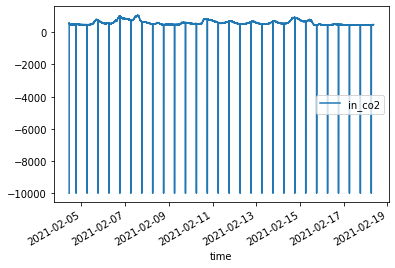

In [4]:
feature_list = input_data.columns
feature = [feature_list[0]]
input_data = input_data[feature]
input_data.plot()

in_co2    0
dtype: int64

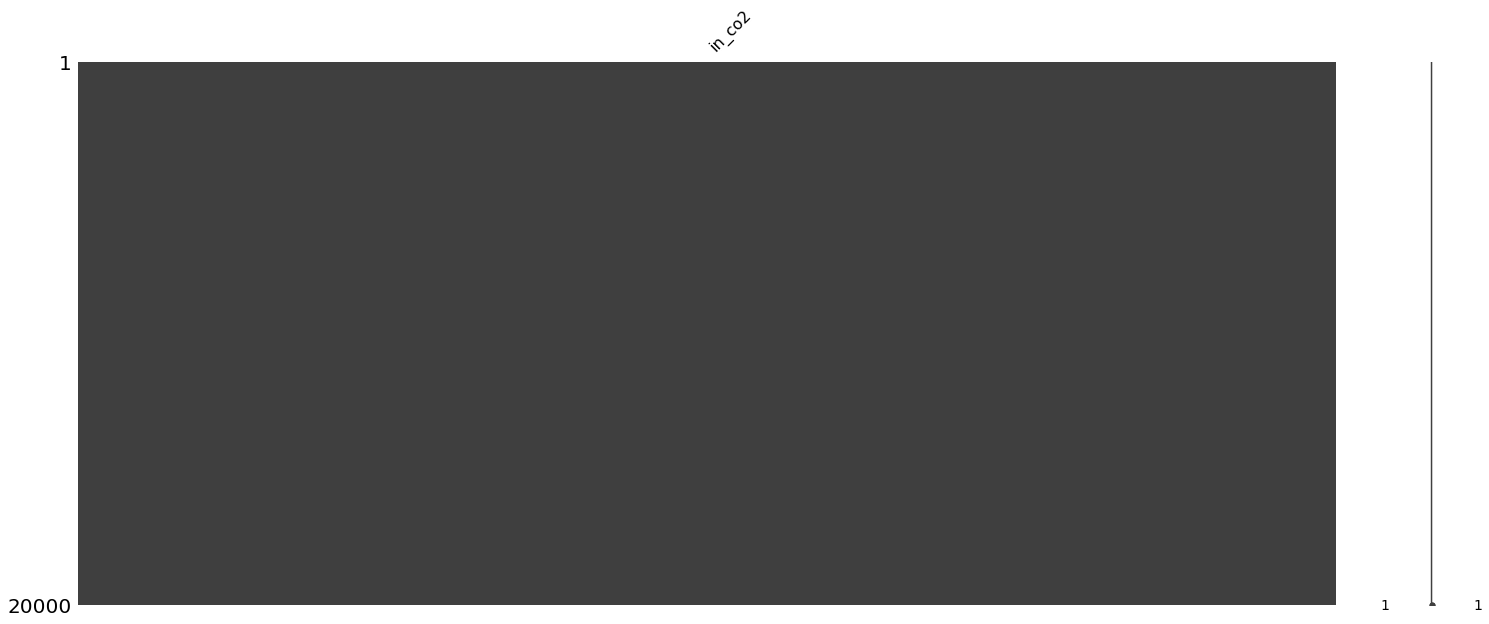

In [5]:
import missingno as msno
msno.matrix(input_data)
input_data.isna().sum()

In [6]:
# DataPreprocessing Class
data = input_data
from clust.preprocessing.dataPreprocessing import DataPreprocessing

refine_param = {'removeDuplication': {'flag': True}, 'staticFrequency': {'flag': True, 'frequency': None}}
# refine_param = {'removeDuplication': {'flag': True}, 'staticFrequency': {'flag': True, 'frequency': "3H"}}

refinementData = DataPreprocessing().get_refinedData(data, refine_param)
print(refinementData.head())

                           in_co2
time                             
2021-02-04 10:33:00+00:00 -9999.0
2021-02-04 10:34:00+00:00   552.0
2021-02-04 10:35:00+00:00   597.0
2021-02-04 10:36:00+00:00   540.0
2021-02-04 10:37:00+00:00   521.0


in_co2    49
dtype: int64

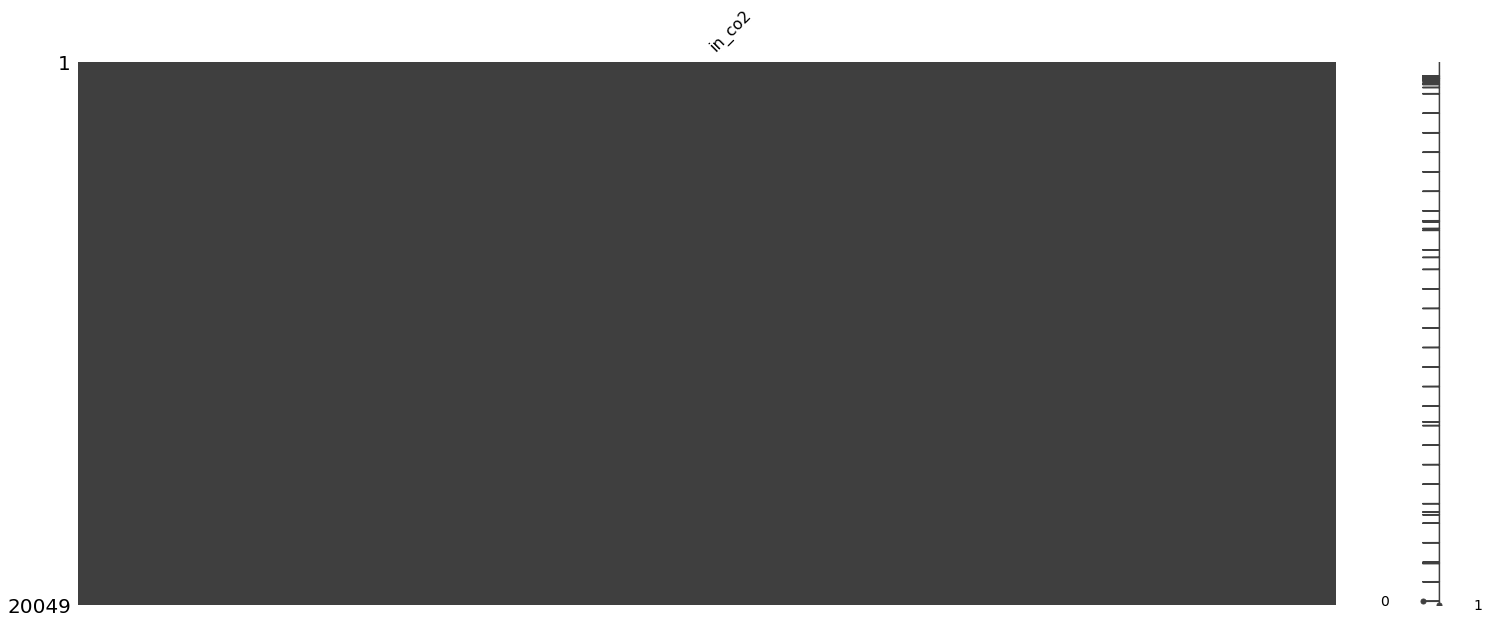

In [7]:
msno.matrix(refinementData)
refinementData.isna().sum()

## 1-2. Certain Outlier to NaN Test

In [8]:
data =refinementData
CertainParam= {'flag': True}
from clust.preprocessing.errorDetection.errorToNaN import errorToNaN 
datawithMoreCertainNaN = errorToNaN().getDataWithCertainNaN(data, CertainParam)

in_co2    78
dtype: int64

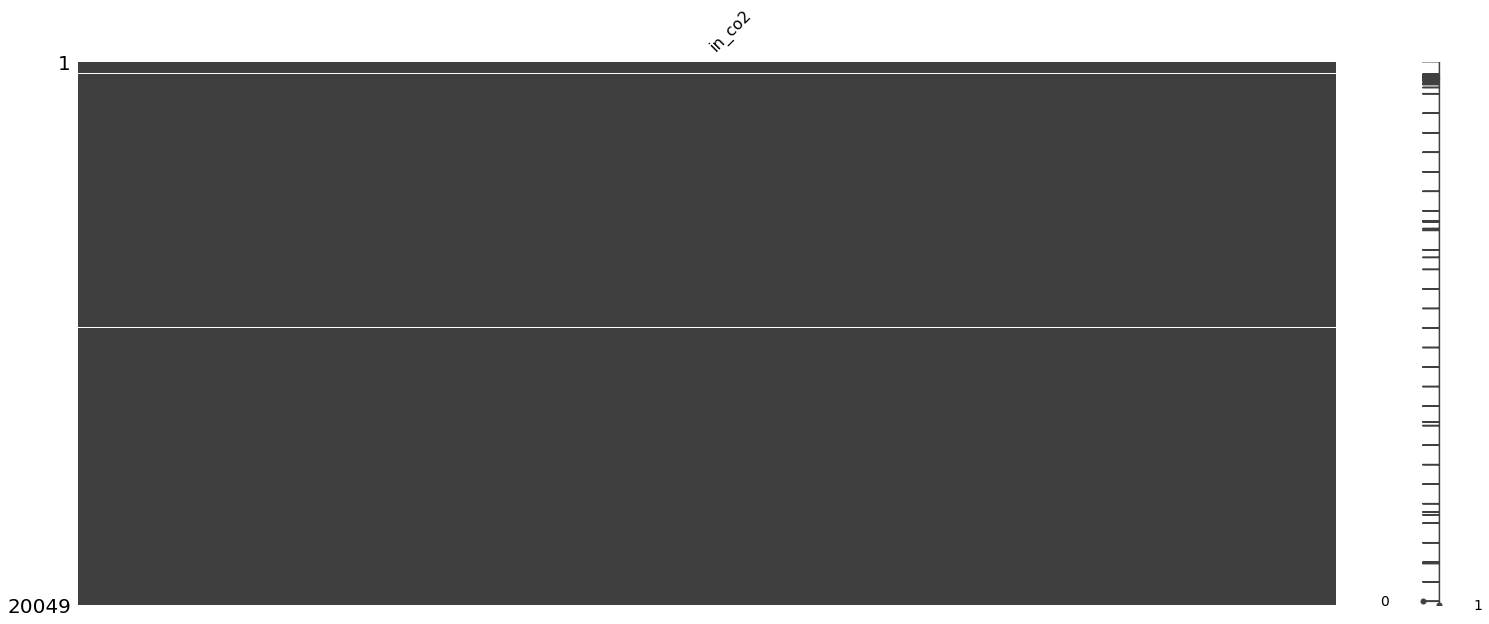

In [9]:
msno.matrix(datawithMoreCertainNaN)
datawithMoreCertainNaN.isna().sum()

<AxesSubplot:xlabel='time'>

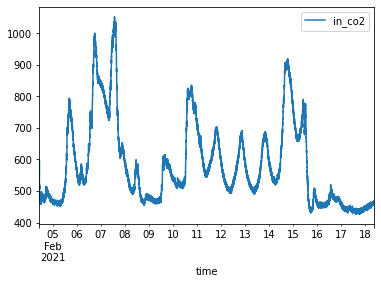

In [10]:
datawithMoreCertainNaN[['in_co2']].plot()

## 1-3. Uncertain Outlier to NaN Test

In [11]:
period = 24*60 # 해당 데이터의 주기가 24*60 정도로 추정됨
percentile1 = 99
# 예제 파라미터를 위한 셋팅
Parameter = {
    "IF":{ # Estimators (1~100)
        'IF_estimators': 100, # ensemble에 활용하는 모델 개수, i(default: 100, 데이터 크기에 적합하게 설정) 
        'IF_max_samples': 'auto', # 각 모델에 사용하는 샘플 개수(샘플링 적용), int or float(default: 'auto') 
        'IF_contamination': (100-percentile1)/100, #'auto', # 모델 학습시 활용되는 데이터의 outlier 비율, ‘auto’ or float(default: ’auto’, float인 경우 0 초과, 0.5 이하로 설정)
        'IF_max_features': 1.0, # 각 모델에 사용하는 변수 개수(샘플링 적용), int or float(default: 1.0)
        'IF_bootstrap': True}, # bootstrap적용 여부, bool(default: False)
    "KDE":{ #leafSize (1~100)
        # Multivariable 가능
        'KDE_bandwidth': 1.0, # kernel의 대역폭, float(default: 1.0)
        'KDE_algorithm': 'auto', # 사용할 tree 알고리즘, {‘kd_tree’,‘ball_tree’,‘auto’}(default: ’auto’) 중 택 1
        'KDE_kernel': 'gaussian', # kernel 종류, {'gaussian’, ‘tophat’, ‘epanechnikov’, ‘exponential’, ‘linear’, ‘cosine’}(default: ’gaussian’) 중 택 1
        'KDE_metric': 'euclidean', # 사용할 거리 척도, str(default: ’euclidean’)
        'KDE_breadth_first': True, # breadth(너비) / depth(깊이) 중 우선순위 방식 정의, bool, True: breadth or False: depth
        'KDE_leaf_size': 40}, # tree 알고리즘에서의 leaf node 개수, int(default: 40)}
    "LOF":{ # Neighbors (1~100) , leafSize (1~100, Integer)
        'LOF_neighbors': 20, # 가까운 이웃 개수, int(default: 20)
        'LOF_algorithm': 'auto', # 가까운 이웃을 정의하기 위한 알고리즘, {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}(default: ’auto’) 중 택 1
        'LOF_leaf_size': 30, # tree 알고리즘에서의 leaf node 개수, int(default: 30)
        'LOF_metric': 'minkowski', # 이웃을 정의하기 위한 거리 척도, str or callable(default: ’minkowski’)
        'LOF_contamination':0.1 # 오염 정도 (default: 0.2) (0~0.2]
    },
    "MoG": { #Components(1~100)
        'MoG_components': 1, # mixture에 활용하는 component의 개수, int(default: 1)
        'MoG_covariance': 'full', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}(default: ’full’) 중 택 1
        'MoG_max_iter': 100 # EM 방법론 반복 횟수, int(default: 100)
    },
    "SR":{ 
        # Multivariable 불가능해 보임
        'SR_series_window_size': int(period/2), # less than period, int, 데이터 크기에 적합하게 설정
        'SR_spectral_window_size': period, # as same as period, int, 데이터 크기에 적합하게 설정
        'SR_score_window_size': period *2}, # a number enough larger than period, int, period보다 충분히 큰 size로 설정
    "IQR":{ # weight (1~100)
        'weight':100},
    "SD":{# limit (1~100)
        "period":period, "limit":15} 
}

In [12]:
data = datawithMoreCertainNaN
# 두개의 알고리즘을 동시에 쓰는 예제에 대해 파라미터 생성
AlgorithmList =[ 'IF', 'KDE', 'LOF', 'MoG', 'SR', 'IQR', 'SD']
UncertainParameter= {"outlierDetectorConfig":[
    {'algorithm': AlgorithmList[0], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[0]]},
    {'algorithm': AlgorithmList[1], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[1]]},
    {'algorithm': AlgorithmList[2], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[2]]},
    {'algorithm': AlgorithmList[3], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[3]]},
    {'algorithm': AlgorithmList[4], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[4]]},
    {'algorithm': AlgorithmList[5], 'percentile':percentile1 ,'alg_parameter': Parameter[AlgorithmList[5]]}
]}

algorithm1 = AlgorithmList[0]
uncertainParameter= {"outlierDetectorConfig":[
    {'algorithm': algorithm1, 'percentile':percentile1 ,'alg_parameter': Parameter[algorithm1]}
]}

uncertainParam= {'flag': True, "param":uncertainParameter}
uncertainParam

{'flag': True,
 'param': {'outlierDetectorConfig': [{'algorithm': 'IF',
    'percentile': 99,
    'alg_parameter': {'IF_estimators': 100,
     'IF_max_samples': 'auto',
     'IF_contamination': 0.01,
     'IF_max_features': 1.0,
     'IF_bootstrap': True}}]}}

In [13]:
datawithMoreUnCertainNaN = errorToNaN().getDataWithUncertainNaN(data, uncertainParam)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


In [14]:
datawithMoreUnCertainNaN.head()

,in_co2
time,
2021-02-04 10:33:00+00:00,NaN
2021-02-04 10:34:00+00:00,552.0
2021-02-04 10:35:00+00:00,597.0
2021-02-04 10:36:00+00:00,540.0
2021-02-04 10:37:00+00:00,521.0


in_co2    275
dtype: int64

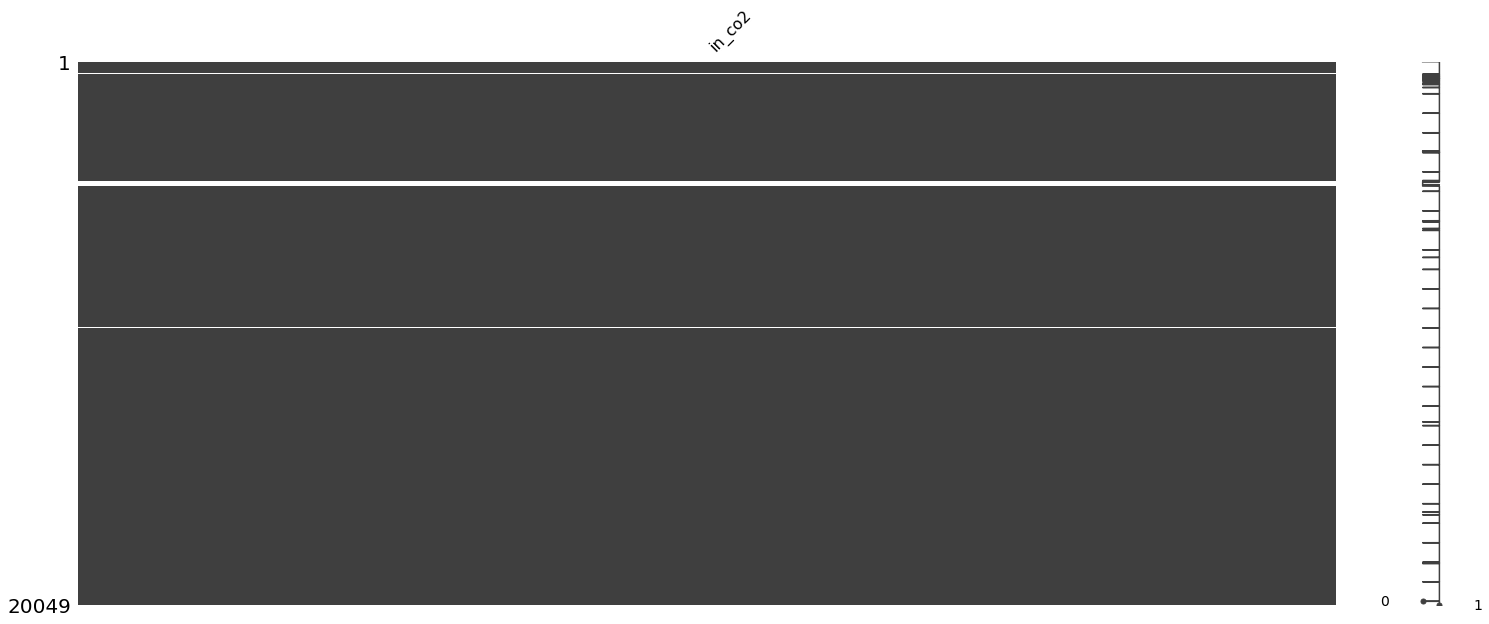

In [15]:
msno.matrix(datawithMoreUnCertainNaN)
datawithMoreUnCertainNaN.isna().sum()

### 1-4. Imputation Test

In [16]:
# Brits일 경우 더 복잡함, 향후 수정 예정
# Imputaion_method == KNN일 경우 파라미터 있음
        
imputation_param = {
    "flag":True,
    "imputation_method":[{"min":0,"max":30,"method":"linear", "parameter":{}}, 
                          #{"min":2,"max":3,"method":"brits", "parameter":{"trainDataPathList":[db_name, ms_name]}},
                        {"min":31,"max":100,"method":"KNN", "parameter":{'n_neighbors':10, 'weights':'uniform' , 'metric':'nan_euclidean' }}
    ],
    "totalNonNanRatio":80
}
data = datawithMoreUnCertainNaN
imputedData = DataPreprocessing().get_imputedData(data, imputation_param)

In [17]:
imputation_param

{'flag': True,
 'imputation_method': [{'min': 0,
   'max': 30,
   'method': 'linear',
   'parameter': {}},
  {'min': 31,
   'max': 100,
   'method': 'KNN',
   'parameter': {'n_neighbors': 10,
    'weights': 'uniform',
    'metric': 'nan_euclidean'}}],
 'totalNonNanRatio': 80}

in_co2    0
dtype: int64

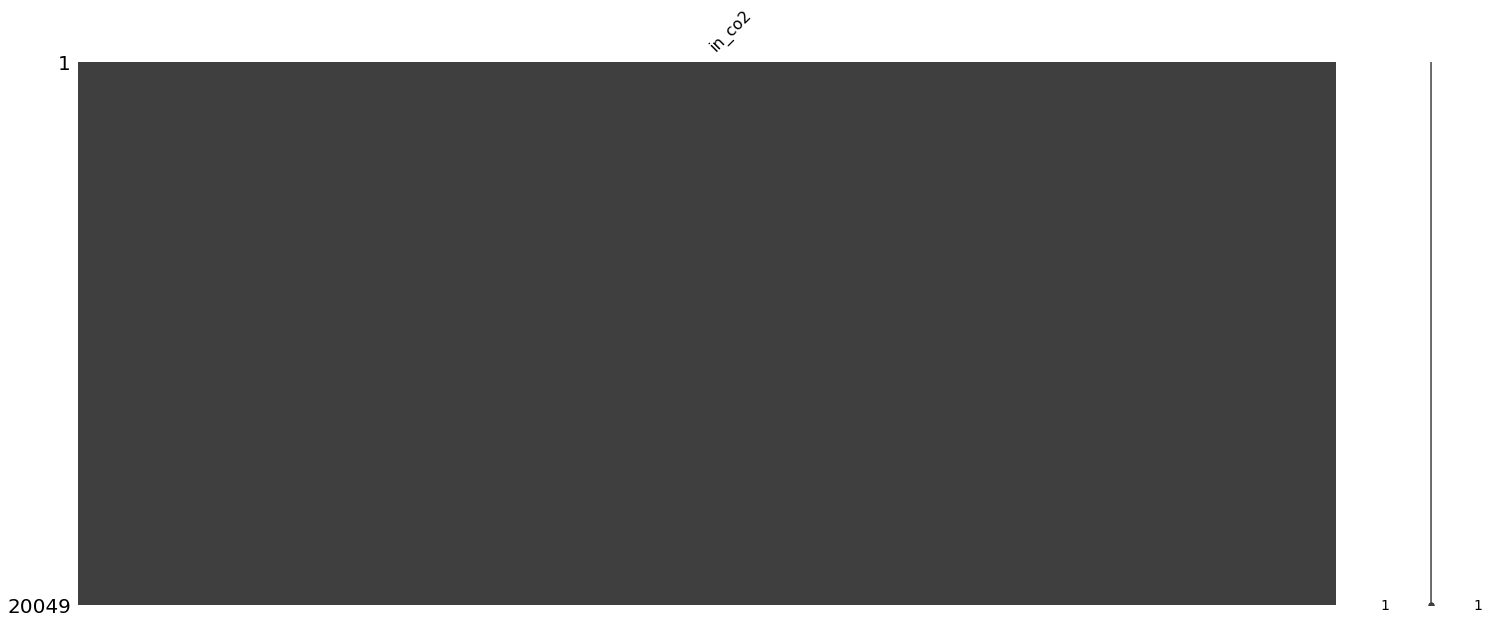

In [18]:
msno.matrix(imputedData)
imputedData.isna().sum()

## 2. Packaged Preprocessing process

In [19]:
from clust.preprocessing.dataPreprocessing import DataProcessing
outlier_param ={
    "certainErrorToNaN":CertainParam, 
    "unCertainErrorToNaN":uncertainParam
}
process_param = {'refine_param':refine_param, 'outlier_param':outlier_param, 'imputation_param':imputation_param}

resultSet = DataProcessing(process_param).all_preprocessing(input_data)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


## 3. Result

key:  original Data Leangth: 20000 Data NaN Length: in_co2    0
dtype: int64


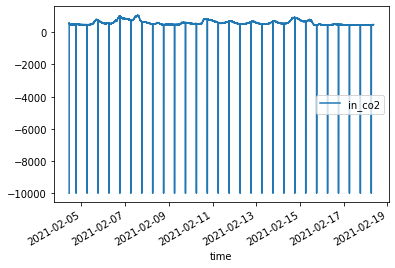

key:  refined_data Data Leangth: 20049 Data NaN Length: in_co2    49
dtype: int64


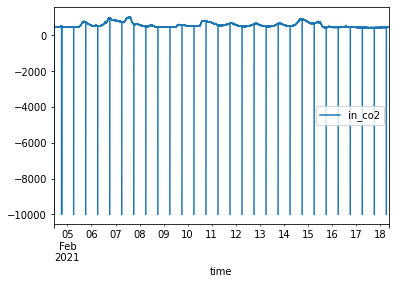

key:  datawithMoreCertainNaN Data Leangth: 20049 Data NaN Length: in_co2    78
dtype: int64


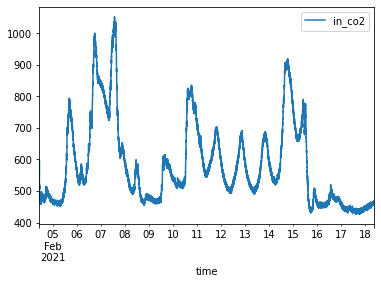

key:  datawithMoreUnCertainNaN Data Leangth: 20049 Data NaN Length: in_co2    279
dtype: int64


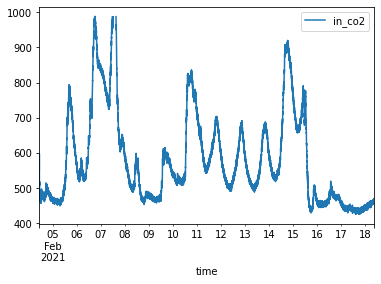

key:  imputed_data Data Leangth: 20049 Data NaN Length: in_co2    32
dtype: int64


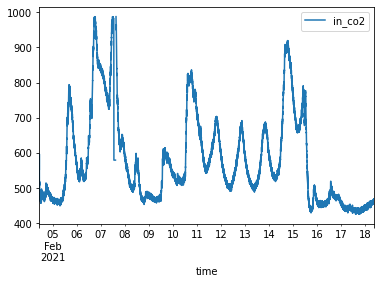

In [20]:
# Check each result
import matplotlib.pyplot as plt
for key in resultSet:
    temp = resultSet[key]
    print("key: ", key, "Data Leangth:", len(temp), "Data NaN Length:", temp.isna().sum())
    temp.plot()
    plt.show()

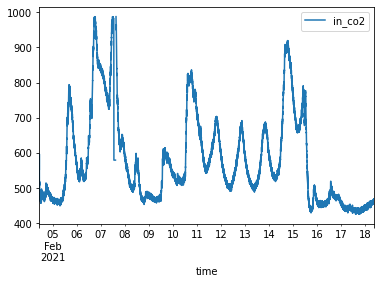

In [21]:
for column in resultSet['imputed_data'].columns:
    resultSet['imputed_data'][[column]].plot()

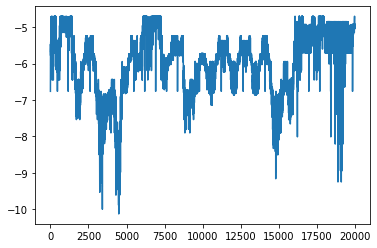

In [22]:
from sklearn.neighbors import KernelDensity
import numpy as np

test =input_data[[input_data.columns[0]]]
kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(test)
log_density = kde.score_samples(test)
plt.plot(log_density)
score = - 1.0 * log_density
indexes = np.where(score > np.percentile(score, 99))[0]

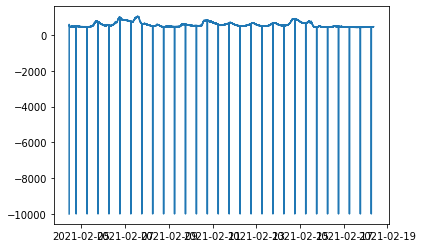

In [23]:
plt.plot(test)

In [24]:
indexes

array([ 3200,  3239,  3240,  3241,  3242,  3243,  3244,  3245,  3246,
        3247,  3248,  3251,  3253,  3255,  3256,  3257,  3259,  3286,
        3287,  3298,  3300,  3312,  3315,  3331,  3337,  3339,  3344,
        3352,  3354,  3359,  3361,  3363,  3364,  3369,  3372,  3377,
        3378,  3379,  3380,  3381,  3383,  3384,  3385,  3387,  3388,
        3390,  3391,  3392,  3393,  3394,  3395,  3396,  3397,  3398,
        3399,  3401,  3404,  3405,  3406,  3407,  3408,  3409,  3410,
        3411,  3412,  3413,  3414,  3415,  3416,  3417,  4299,  4301,
        4305,  4306,  4307,  4308,  4311,  4314,  4315,  4316,  4317,
        4319,  4330,  4335,  4336,  4337,  4338,  4350,  4354,  4356,
        4357,  4359,  4375,  4377,  4382,  4384,  4387,  4393,  4396,
        4399,  4405,  4407,  4417,  4418,  4419,  4420,  4422,  4424,
        4425,  4429,  4431,  4438,  4443,  4444,  4445,  4446,  4455,
        4457,  4461,  4466,  4469,  4471,  4472,  4473,  4475,  4480,
        4482,  4483,

In [25]:
process_param

{'refine_param': {'removeDuplication': {'flag': True},
  'staticFrequency': {'flag': True, 'frequency': None}},
 'outlier_param': {'certainErrorToNaN': {'flag': True},
  'unCertainErrorToNaN': {'flag': True,
   'param': {'outlierDetectorConfig': [{'algorithm': 'IF',
      'percentile': 99,
      'alg_parameter': {'IF_estimators': 100,
       'IF_max_samples': 'auto',
       'IF_contamination': 0.01,
       'IF_max_features': 1.0,
       'IF_bootstrap': True}}]}}},
 'imputation_param': {'flag': True,
  'imputation_method': [{'min': 0,
    'max': 30,
    'method': 'linear',
    'parameter': {}},
   {'min': 31,
    'max': 100,
    'method': 'KNN',
    'parameter': {'n_neighbors': 10,
     'weights': 'uniform',
     'metric': 'nan_euclidean'}}],
  'totalNonNanRatio': 80}}

## Default Test

In [26]:
from datetime import date, timedelta
frequency_min = 30
frequencyMinTimeDelta= timedelta(minutes=frequency_min)

In [27]:
from clust.preprocessing.dataPreprocessing import DataProcessing
#frequency = [None| DateOffset|Timedelta|str]
refine_param = {'removeDuplication': {'flag': True}, 'staticFrequency': {'flag': True, 'frequency': frequencyMinTimeDelta}}
CertainParam= {'flag': True}
uncertainParam= {'flag': False, "param":{}}
outlier_param ={
    "certainErrorToNaN":CertainParam, 
    "unCertainErrorToNaN":uncertainParam
}
imputation_param = {
    "flag":False
}

process_param = {'refine_param':refine_param, 'outlier_param':outlier_param, 'imputation_param':imputation_param}
partialP = DataProcessing(process_param)
multiple_dataset = partialP.all_preprocessing(input_data)

In [28]:
resultSet.keys()

dict_keys(['original', 'refined_data', 'datawithMoreCertainNaN', 'datawithMoreUnCertainNaN', 'imputed_data'])

In [29]:
resultSet

{'original':                            in_co2
 time                             
 2021-02-04 10:33:00+00:00 -9999.0
 2021-02-04 10:34:00+00:00   552.0
 2021-02-04 10:35:00+00:00   597.0
 2021-02-04 10:36:00+00:00   540.0
 2021-02-04 10:37:00+00:00   521.0
 ...                           ...
 2021-02-18 08:37:00+00:00   460.0
 2021-02-18 08:38:00+00:00   466.0
 2021-02-18 08:39:00+00:00   467.0
 2021-02-18 08:40:00+00:00   459.0
 2021-02-18 08:41:00+00:00   466.0
 
 [20000 rows x 1 columns],
 'refined_data':                            in_co2
 time                             
 2021-02-04 10:33:00+00:00 -9999.0
 2021-02-04 10:34:00+00:00   552.0
 2021-02-04 10:35:00+00:00   597.0
 2021-02-04 10:36:00+00:00   540.0
 2021-02-04 10:37:00+00:00   521.0
 ...                           ...
 2021-02-18 08:37:00+00:00   460.0
 2021-02-18 08:38:00+00:00   466.0
 2021-02-18 08:39:00+00:00   467.0
 2021-02-18 08:40:00+00:00   459.0
 2021-02-18 08:41:00+00:00   466.0
 
 [20049 rows x 1 columns],
 'da